In [1]:
from inflation_analysis import grouping, calculate_price_indexes
from tabulate import tabulate
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


# Parameters
start_year = 2019
end_year = 2022
data_folder="/Users/roykisluk/Downloads/Consumer_Expenditure_Survey/"
top_n = 10
base_year = start_year
years=range(start_year, end_year+1)

groups, total_mmb = grouping(start_year, end_year, cex_data_folder = data_folder)
groups_mmb = {key: {} for key in groups.keys()}
for key in groups:
    for year in years:
        groups_mmb[key][year] = groups[key][year][['misparmb']]

group_analysis = {}
for key in tqdm(groups.keys(), desc="Processing groups"):
    combined_df, combined_secondary_df, combined_primary_df, yearly_price_index = calculate_price_indexes(
        start_year, end_year, base_year, group_mmb=groups_mmb[key], cex_data_folder=data_folder, verbose=False
    )
    group_analysis[key] = {
        'combined_secondary_df': combined_secondary_df,
        'combined_primary_df': combined_primary_df,
        'yearly_price_index': yearly_price_index
    }


Processing groups: 100%|██████████| 11/11 [00:39<00:00,  3.63s/it]


In [2]:
gen_pop_df, gen_pop_secondary_df, gen_pop_primary_df, gen_pop_yearly_price_index = calculate_price_indexes(start_year, end_year, base_year, cex_data_folder=data_folder, verbose=False)

In [3]:
group_counts = {group: {year: len(groups_mmb[group][year]) for year in groups_mmb[group]} for group in groups_mmb}
# Create a dataframe with number of observations per year per group
observations_df = pd.DataFrame(group_counts).T

# Calculate the relative share of each group per year
total_observations_per_year = observations_df.sum(axis=0)
relative_share_df = observations_df.div(total_observations_per_year, axis=1) * 100

# Combine the absolute and relative values into a single dataframe
combined_df = observations_df.join(relative_share_df, rsuffix='_share')

# Display the dataframe
print(tabulate(combined_df, headers='keys', tablefmt='psql'))

+-----------+--------+--------+--------+--------+--------------+--------------+--------------+--------------+
|           |   2019 |   2020 |   2021 |   2022 |   2019_share |   2020_share |   2021_share |   2022_share |
|-----------+--------+--------+--------+--------+--------------+--------------+--------------+--------------|
| Arabs     |   1103 |    513 |    951 |    727 |     10.9273  |     7.49014  |     11.1476  |      9.51944 |
| Haredi    |    565 |    440 |    551 |    595 |      5.59738 |     6.4243   |      6.4588  |      7.79102 |
| Low_inc   |    646 |    397 |    503 |    515 |      6.39984 |     5.79647  |      5.89614 |      6.74349 |
| High_inc  |   1848 |   1432 |   1479 |   1162 |     18.3079  |    20.9082   |     17.3368  |     15.2154  |
| Young     |   1108 |    718 |    877 |    820 |     10.9768  |    10.4833   |     10.2802  |     10.7372  |
| Old       |   2279 |   1786 |   1779 |   1663 |     22.5778  |    26.0768   |     20.8534  |     21.7756  |
| Low_SES 

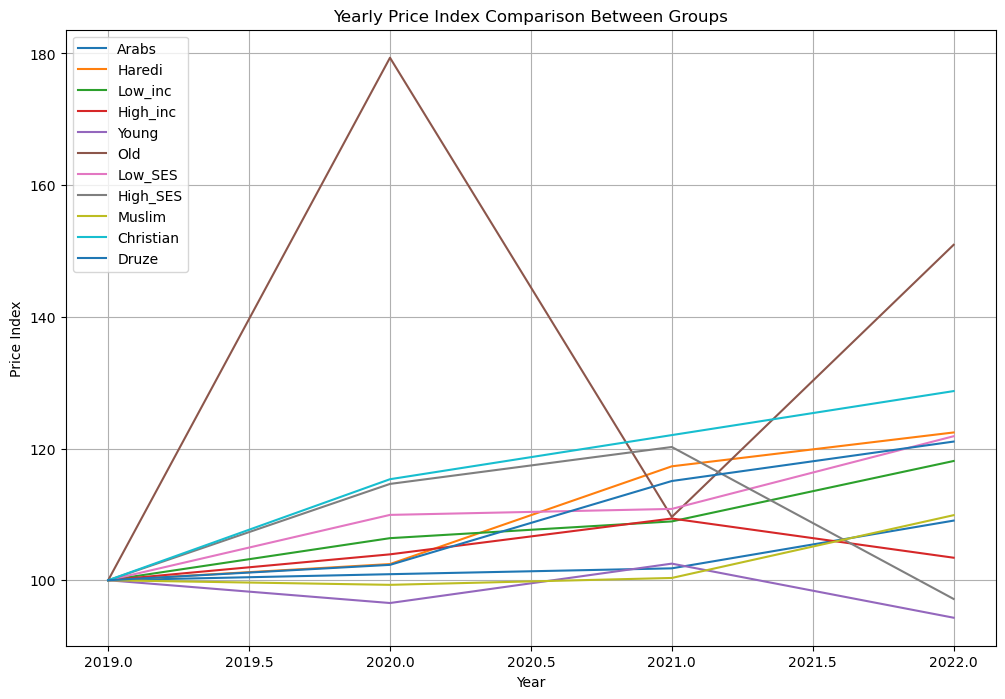

In [4]:
# Extract yearly price indexes for each group
group_yearly_price_indexes = {group: group_analysis[group]['yearly_price_index'] for group in group_analysis}

# Plot the yearly price indexes
plt.figure(figsize=(12, 8))
for group, price_indexes in group_yearly_price_indexes.items():
    years = list(price_indexes.keys())
    indexes = list(price_indexes.values())
    plt.plot(years, indexes, label=group)

plt.xlabel('Year')
plt.ylabel('Price Index')
plt.title('Yearly Price Index Comparison Between Groups')
plt.legend()
plt.grid(True)
plt.show()

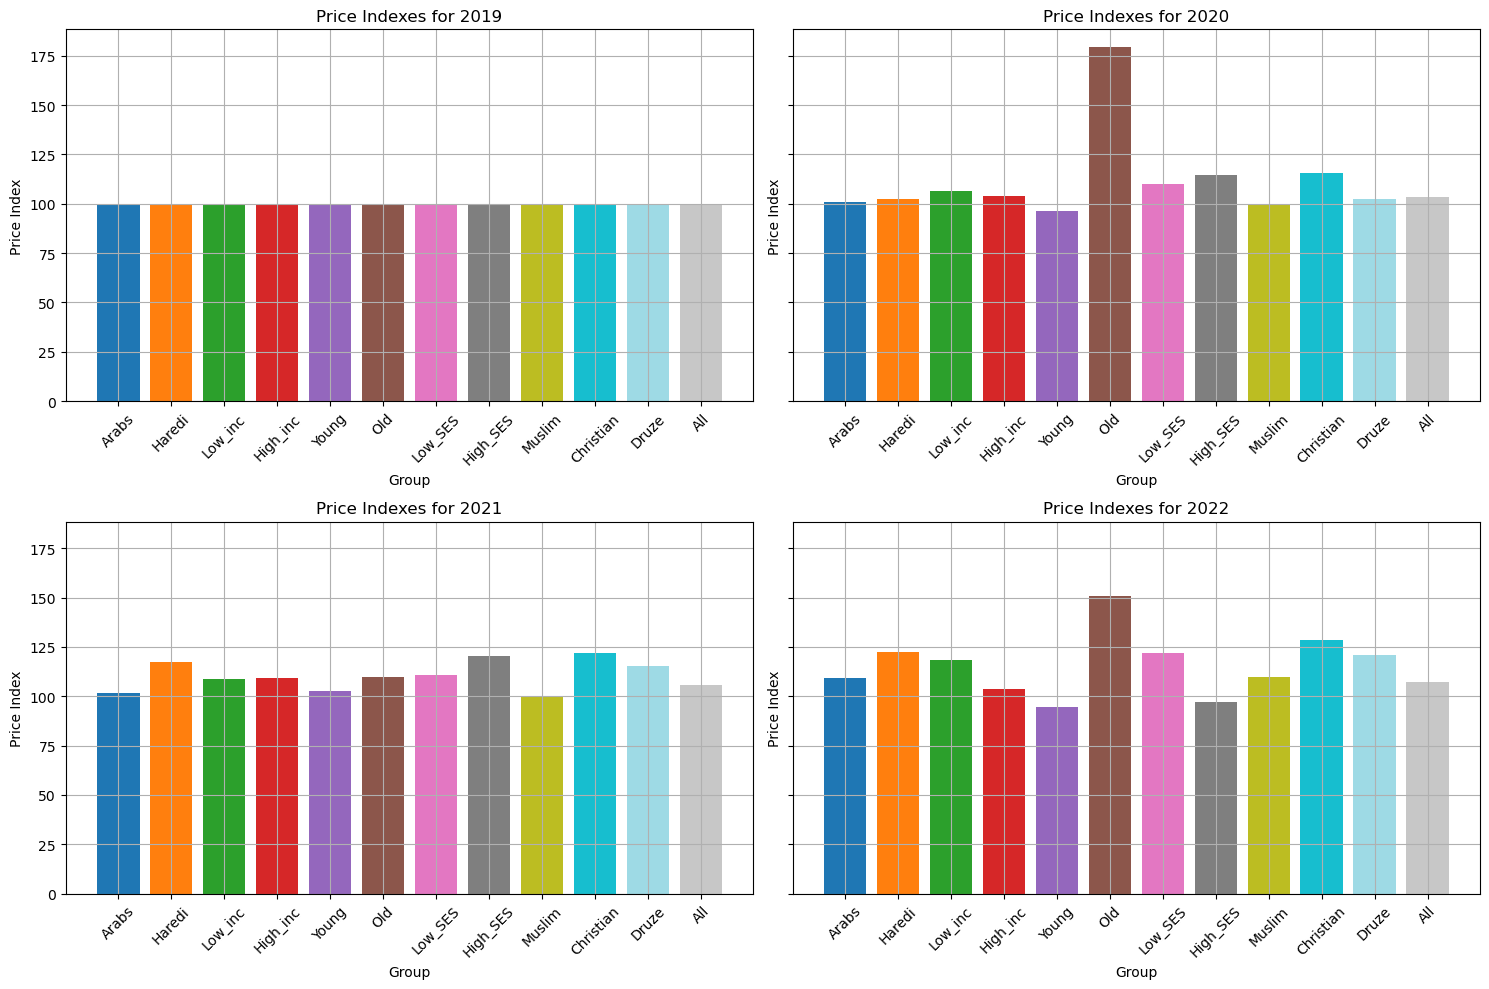

In [5]:
# Extract yearly price indexes for each group including general population
group_yearly_price_indexes = {group: group_analysis[group]['yearly_price_index'] for group in group_analysis}
group_yearly_price_indexes['All'] = gen_pop_yearly_price_index

# Define colors for each group
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9edae5', '#c7c7c7']

# Create subplots for each year
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    groups = list(group_yearly_price_indexes.keys())
    price_indexes = [group_yearly_price_indexes[group][year] for group in groups]
    ax.bar(groups, price_indexes, color=colors)
    ax.set_title(f'Price Indexes for {year}')
    ax.set_xlabel('Group')
    ax.set_ylabel('Price Index')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

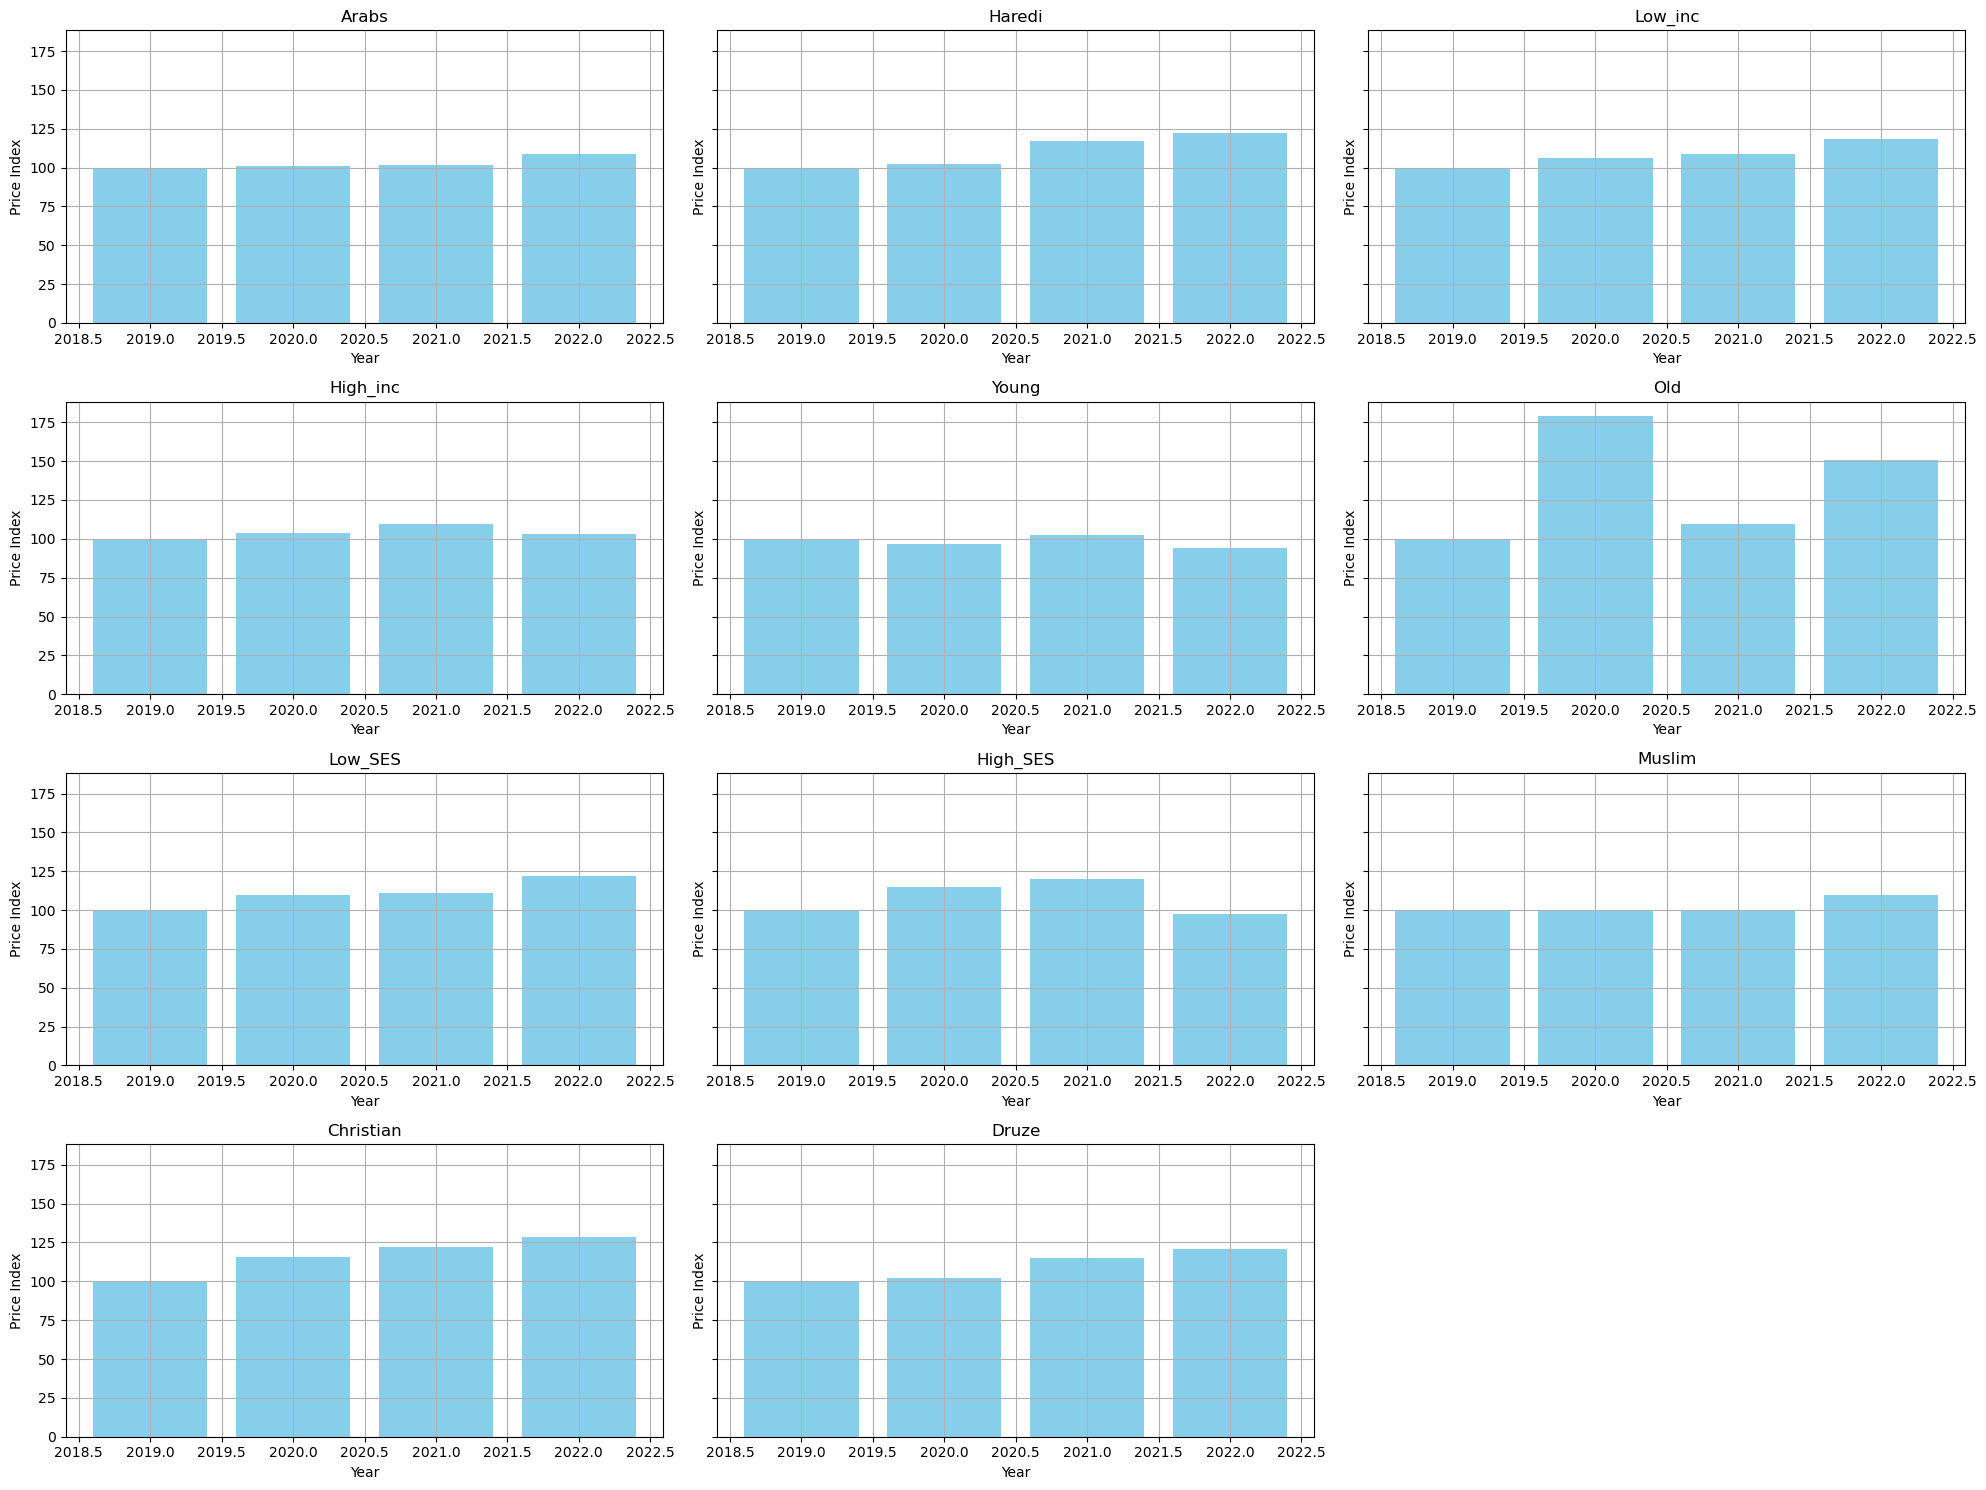

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
axes = axes.flatten()

for i, (group, data) in enumerate(group_analysis.items()):
    yearly_price_index = data['yearly_price_index']
    years = list(yearly_price_index.keys())
    indexes = list(yearly_price_index.values())
    
    axes[i].bar(years, indexes, color='skyblue')
    axes[i].set_title(group)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Price Index')
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
for group, analysis in group_analysis.items():
    # Calculate the weight differences between the group and the general population for secondary categories
    weight_diff_df = analysis['combined_secondary_df'].copy()
    weight_diff_df['weight_diff'] = weight_diff_df['weight'] - gen_pop_secondary_df['weight']

    # Sort by the absolute value of the weight differences in descending order
    weight_diff_df['abs_weight_diff'] = weight_diff_df['weight_diff'].abs()
    sorted_weight_diff_df = weight_diff_df.sort_values(by='abs_weight_diff', ascending=False)

    # Display the top_n largest gaps using tabulate
    print(f"Group: {group}")
    print(tabulate(sorted_weight_diff_df.head(top_n)[['Year', 'prodcode', 'description', 'weight', 'weight_diff']], headers='keys', tablefmt='psql'))
    print("\n")

Group: Arabs
+-----+--------+------------+-----------------------------------------+------------+---------------+
|     |   Year |   prodcode | description                             |     weight |   weight_diff |
|-----+--------+------------+-----------------------------------------+------------+---------------|
| 249 |   2022 |        395 | Personal Jewelry And Watches            | 0.00278528 |    -0.131559  |
| 116 |   2020 |        383 | Vehicle Expenses                        | 0.124914   |     0.121741  |
|  55 |   2019 |        385 | Mail Telephone And Communication        | 0.0141179  |    -0.121148  |
| 179 |   2021 |        383 | Vehicle Expenses                        | 0.122662   |     0.116189  |
|  53 |   2019 |        383 | Vehicle Expenses                        | 0.125787   |     0.11603   |
| 242 |   2022 |        383 | Vehicle Expenses                        | 0.127554   |     0.108443  |
| 119 |   2020 |        391 | Cigarettes Tobacco And Smoking Supplies | 0.0300

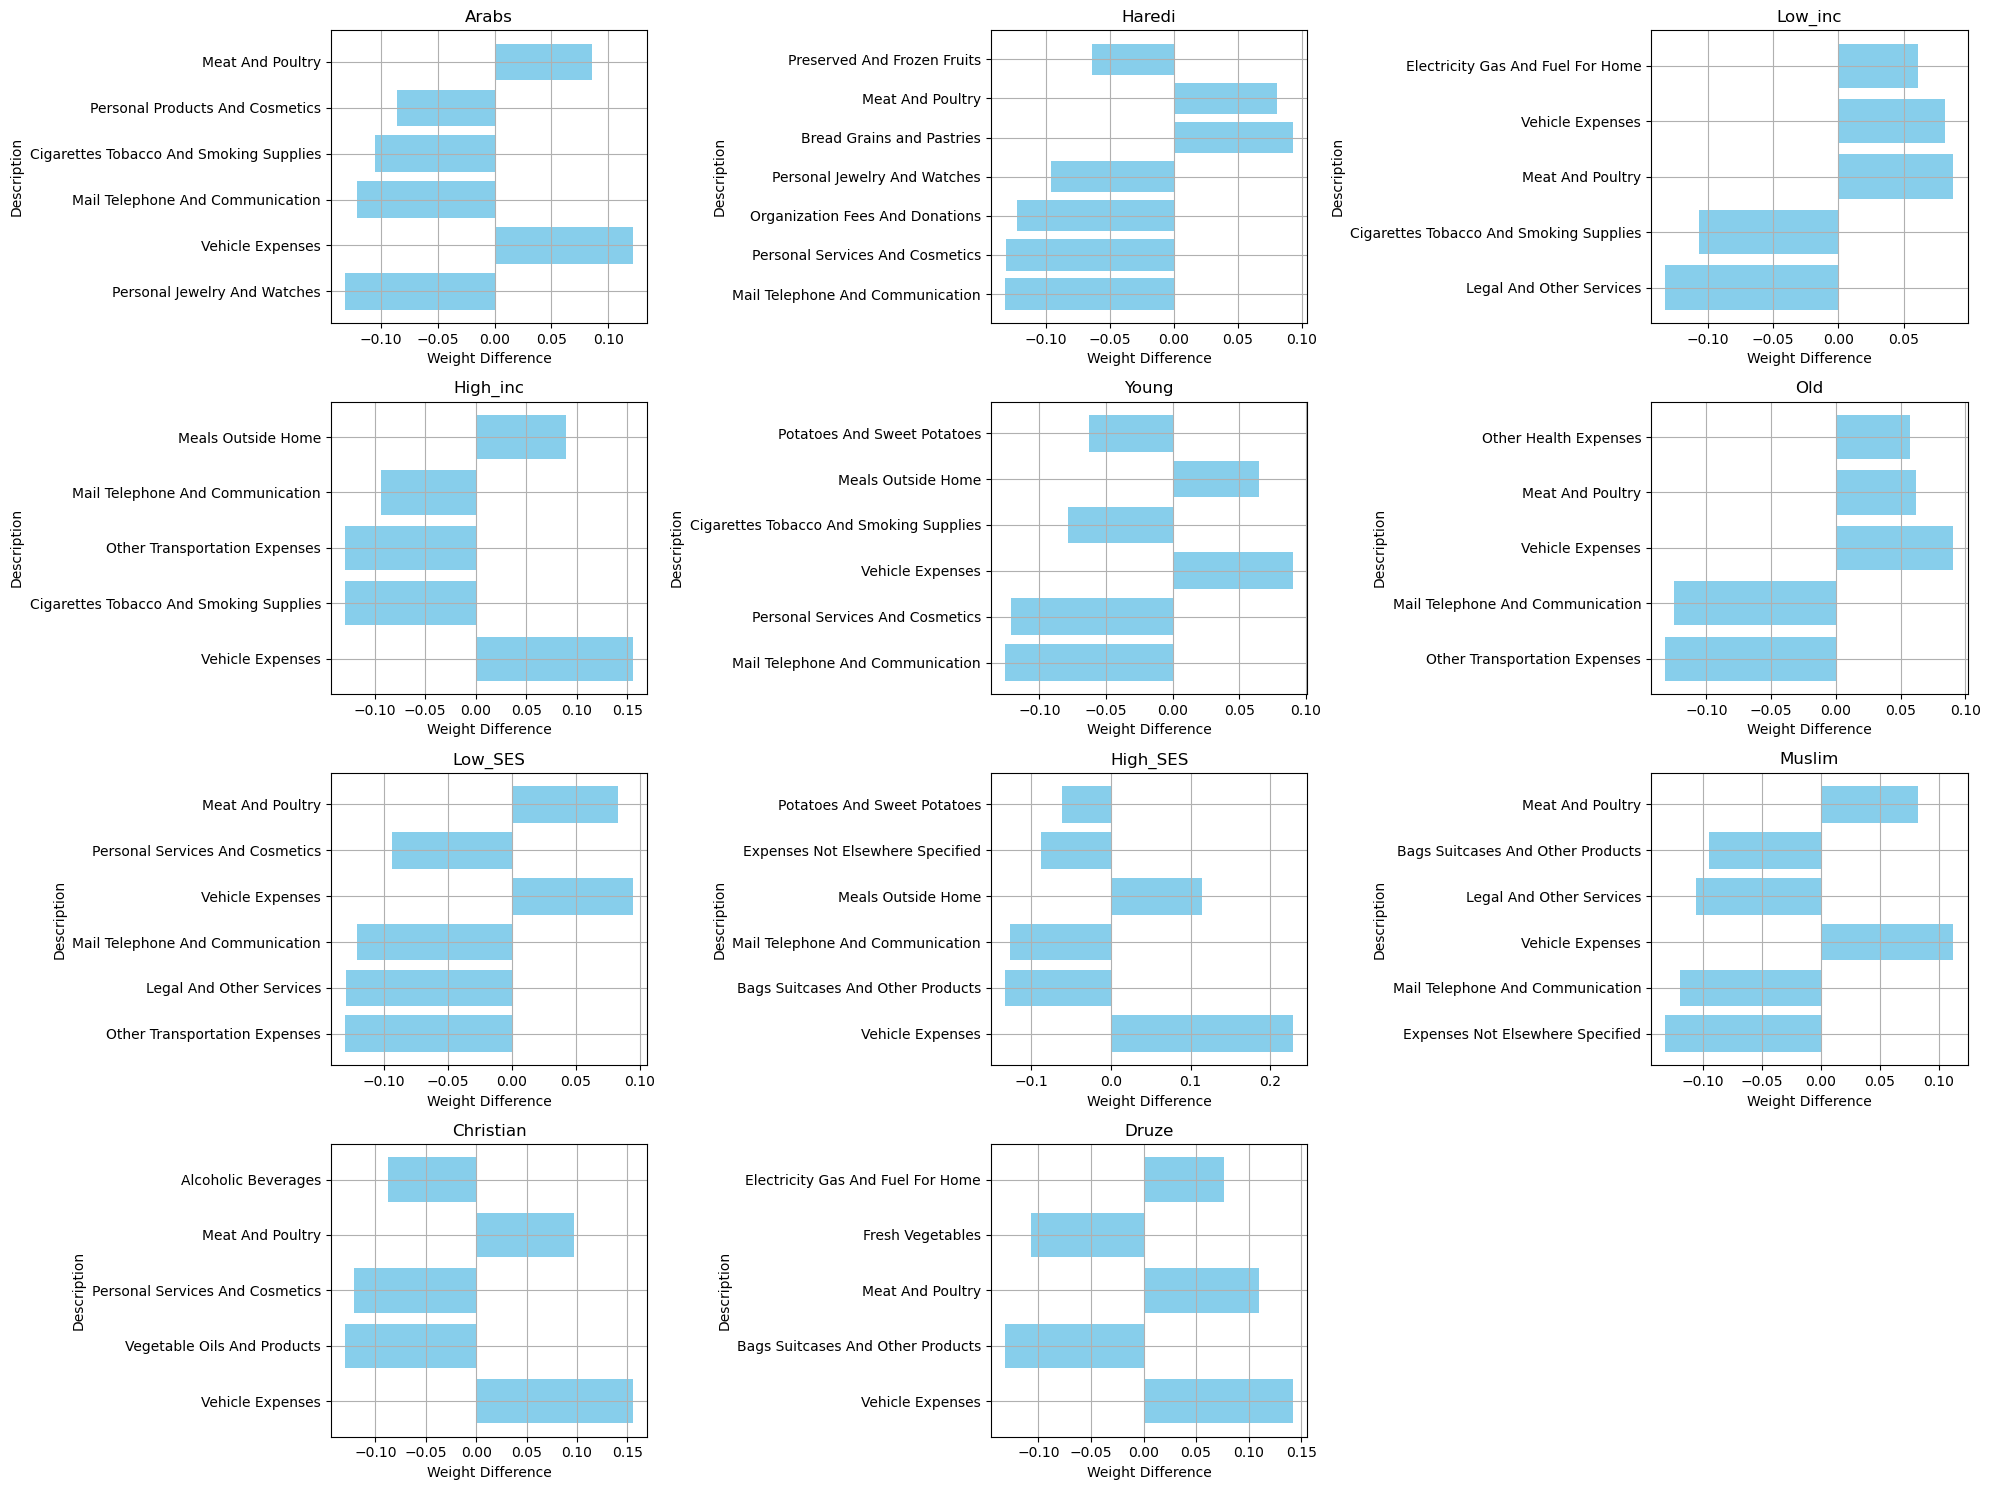

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=False)
axes = axes.flatten()

for i, (group, analysis) in enumerate(group_analysis.items()):
    # Calculate the weight differences between the group and the general population for secondary categories
    weight_diff_df = analysis['combined_secondary_df'].copy()
    weight_diff_df['weight_diff'] = weight_diff_df['weight'] - gen_pop_secondary_df['weight']

    # Sort by the absolute value of the weight differences in descending order
    weight_diff_df['abs_weight_diff'] = weight_diff_df['weight_diff'].abs()
    sorted_weight_diff_df = weight_diff_df.sort_values(by='abs_weight_diff', ascending=False)

    # Replace NaN values in 'description' with an empty string
    sorted_weight_diff_df['description'] = sorted_weight_diff_df['description'].fillna('')

    # Select the top n largest gaps
    top_n_weight_diff_df = sorted_weight_diff_df.head(top_n)

    # Plot the top n largest gaps
    axes[i].barh(top_n_weight_diff_df['description'], top_n_weight_diff_df['weight_diff'], color='skyblue')
    axes[i].set_title(group)
    axes[i].set_xlabel('Weight Difference')
    axes[i].set_ylabel('Description')
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


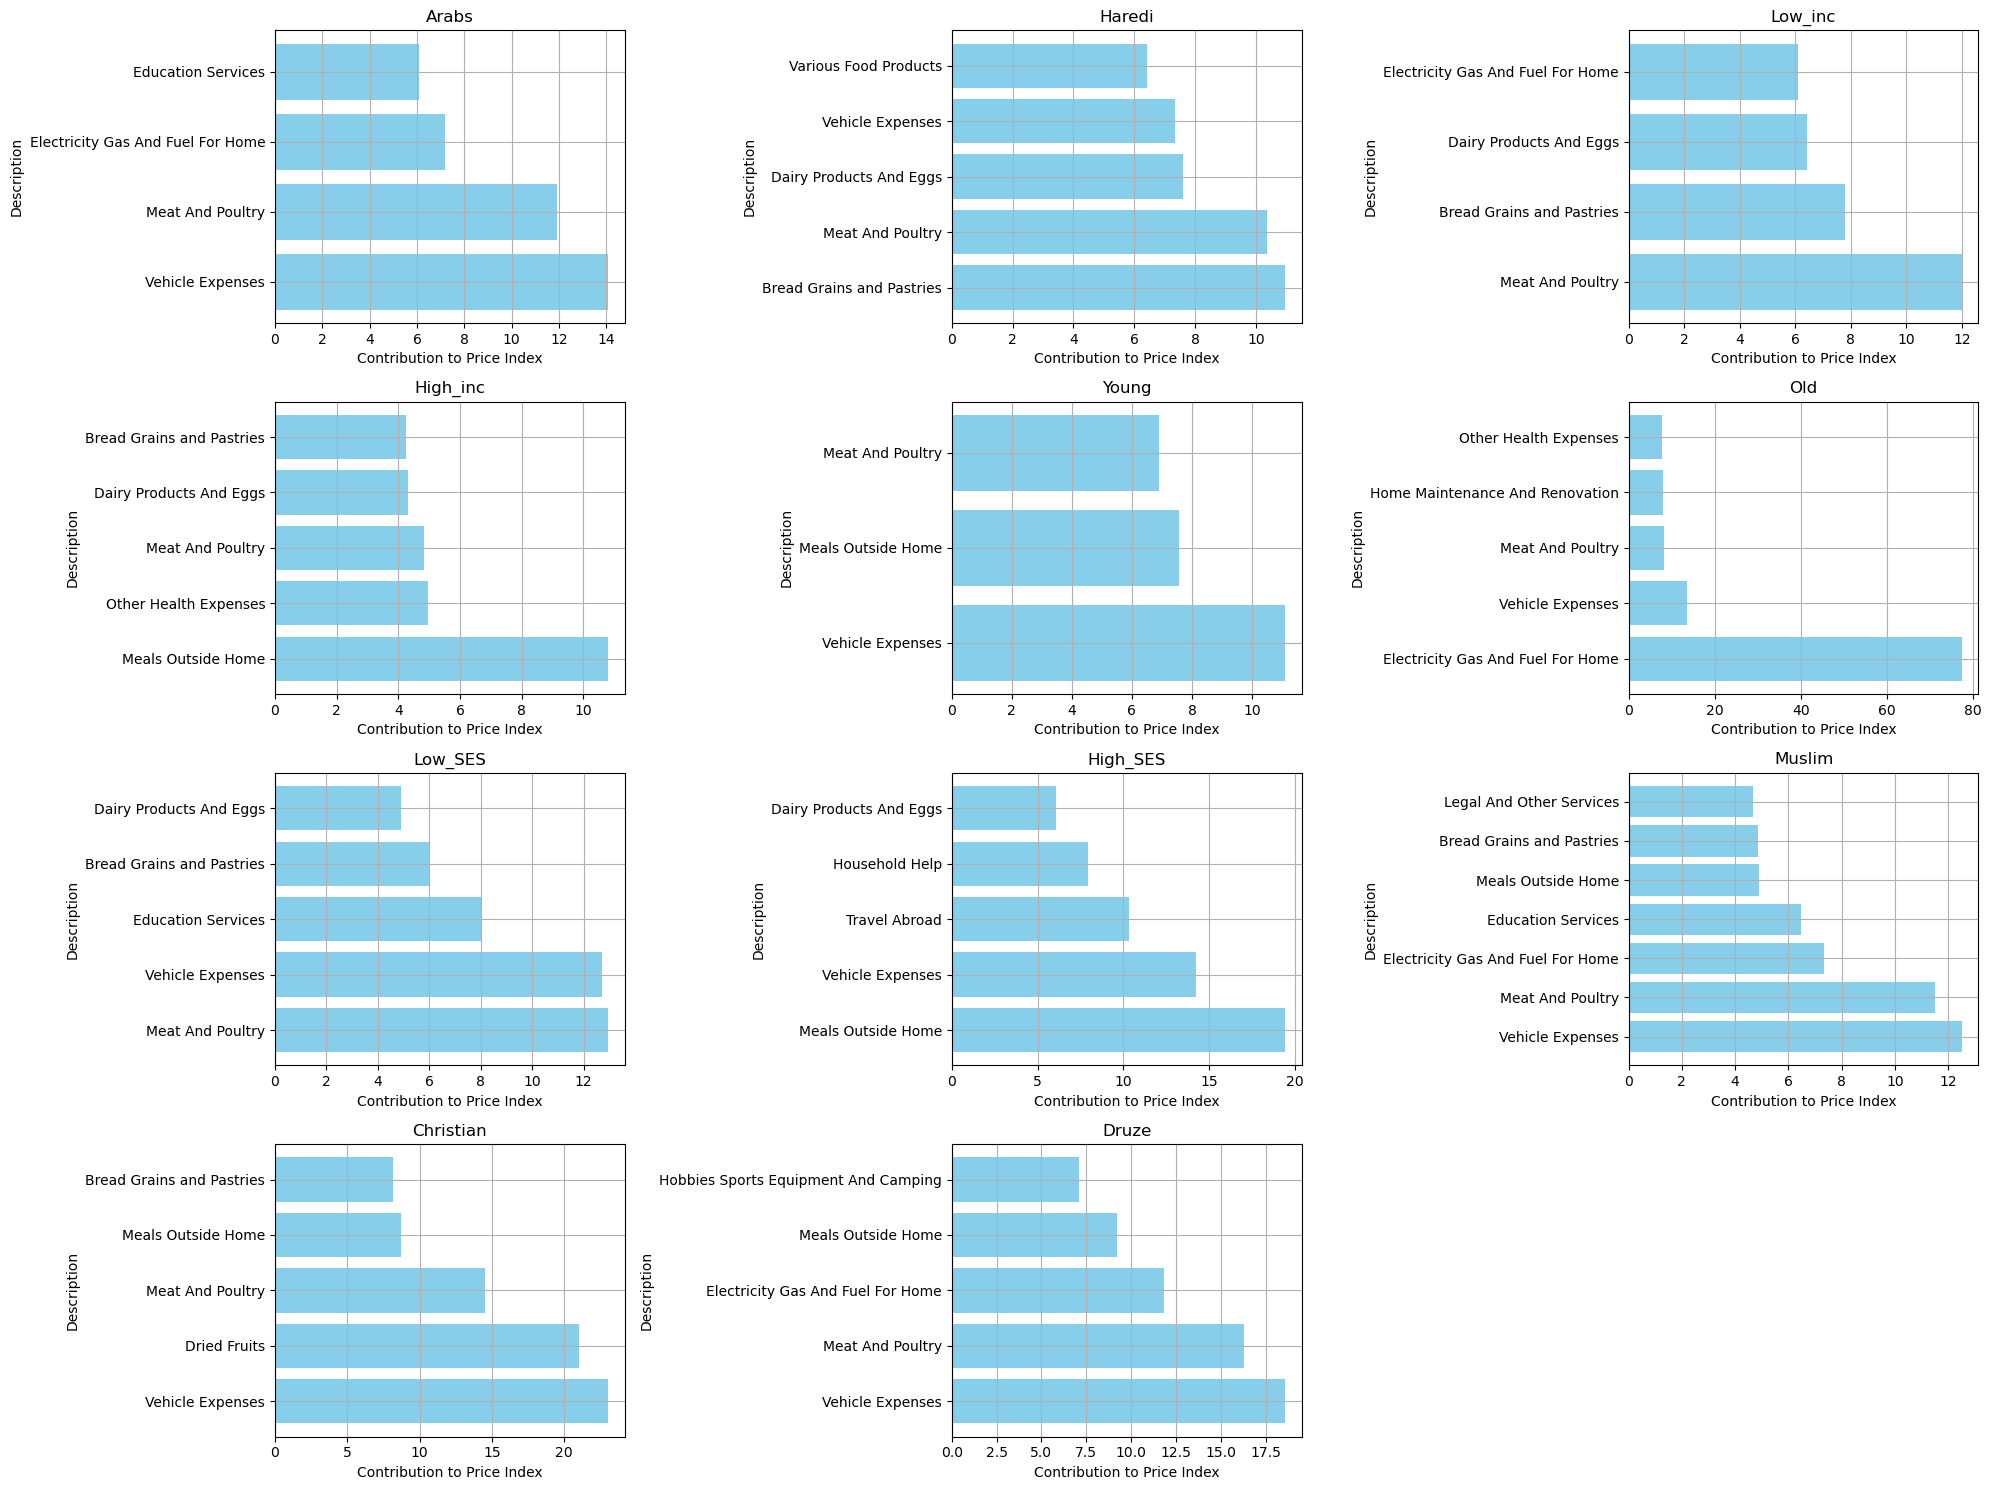

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=False)
axes = axes.flatten()

for i, (group, analysis) in enumerate(group_analysis.items()):
    secondary_df = analysis['combined_secondary_df']
    # Filter for increases in price indexes
    increased_price_df = secondary_df[secondary_df['price_index'] > 100]
    # Calculate the contribution to the yearly price index
    increased_price_df = increased_price_df.copy()  # Ensure you're working with a copy
    increased_price_df.loc[:, 'contribution'] = increased_price_df['price_index'] * increased_price_df['weight']    
    # Sort by contribution in descending order
    top_contributors = increased_price_df.sort_values(by='contribution', ascending=False).head(top_n)
    
    # Replace NaN values in 'description' with a placeholder text
    top_contributors['description'] = top_contributors['description'].fillna('No Description')
    
    # Plot the top contributors
    axes[i].barh(top_contributors['description'], top_contributors['contribution'], color='skyblue')
    axes[i].set_title(group)
    axes[i].set_xlabel('Contribution to Price Index')
    axes[i].set_ylabel('Description')
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()